# VAE with the CIFAR100 dataset
Training of a VAE on the Cifardataset.

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, utils, models
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from torch import optim
import os
from os.path import exists


## !! For Checkpointing!!!

# Path to saving the model
save_model_path = "../trainedModels/VAE_CIFAR100.pth"
save_loss_path = "../plottables/VAE_CIFAR100.pth"

## WARNING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This boolean will completely wipe any past checkpoints or progress.
# ASSIGN IT WITH CARE.
completelyRestartTrain = True

## Important if you want to train again, set this to True
tryResumeTrain = True

# Inarguably a weird place to initialize the number of epochs
# but it is a magic tool that will come in handy later.


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE} device")

Using cpu device


### Message func

In [3]:
def msg(
    message: str,
):
    """
    Input:
        message (str): a message of type string, which will be printed to the terminal
            with some decoration.

    Description:
        This function takes a message and prints it nicely

    Output:
        This function has no output, it prints directly to the terminal
    """

    # word_list makes sure that the output of msg is more readable
    sentence_list = message.split(sep="\n")
    # the max-function can apparently be utilised like this:
    longest_sentence = max(sentence_list, key=len)

    n = len(longest_sentence)
    n2 = n // 2 - 1
    print(">" * n2 + "  " + "<" * n2)
    print(message)
    print(">" * n2 + "  " + "<" * n2 + "\n")

## Downloading data

In [4]:
BATCH_SIZE = 32 #128
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42
NUM_WORKERS = 4

# Setting seeds ##############################################
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
##############################################################

trainval_set = datasets.CIFAR100(
    root = '../data/datasetCIFAR100',
    train = True,                         
    transform = ToTensor(), 
    download = True
    )

test_set = datasets.CIFAR100(
    root = '../data/datasetCIFAR100', 
    train = False, 
    transform = ToTensor()
    )

train_num = int(len(trainval_set) * (1 - VALIDATION_SPLIT))
train_set, val_set = random_split(trainval_set, [train_num, len(trainval_set) - train_num])
msg("Split train data into trainset and validation set.")

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )


classes = trainval_set.classes # or class_to_idx

Files already downloaded and verified
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<
Split train data into trainset and validation set.
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<



## Define model and train

Models from [here](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py) and VAE structure from here [git](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial)

In [5]:
cfg = {
    'VGG9': [64, 'M', 128, 'M', 256, 256, 'M', 512, 'M', 512, 'M'],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class Encoder(nn.Module):
    
    def __init__(self, vgg_name, input_dim, latent_dim):

        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.features = self._make_layers(cfg[vgg_name])
        self.FC_mean = nn.Conv2d(cfg[vgg_name][-2], latent_dim, kernel_size=1) # NOTE: -2 because last element is always "M"
        self.FC_logvar = nn.Conv2d(cfg[vgg_name][-2], latent_dim, kernel_size=1)

    def forward(self, x):
        out = self.features(x)
        #out = out.view(out.size(0), -1) # Flatten(?)
        mean = self.FC_mean(out)
        mean = mean.reshape(mean.size(0), mean.size(1), -1)
        mean = torch.mean(mean, dim=-1, keepdim=True).unsqueeze(-1) # batchSize, latent, 1, 1

        log_var = self.FC_logvar(out)
        log_var = log_var.reshape(log_var.size(0), log_var.size(1), -1)
        log_var = torch.mean(log_var, dim=-1, keepdim=True).unsqueeze(-1) # batchSize, latent, 1, 1
        return mean, log_var
      

    def _make_layers(self, cfg):
        layers = []
        in_channels = self.input_dim
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.GELU()] # changed from ReLU
                in_channels = x
        
        return nn.Sequential(*layers)

class Decoder(nn.Module):
    # Tjek Forward, og går den fra lille til stor?
    def __init__(self, vgg_name, latent_dim, output_dim):

        super(Decoder, self).__init__()
        #cfg[vgg_name] = [latent_dim,*cfg[vgg_name]] # first layer always input size of image
        self.latent_dim = latent_dim
        self.features = self._make_layers(cfg[vgg_name])
        self.FC_output = nn.Conv2d(cfg[vgg_name][-2], output_dim, kernel_size=1) # when kernel size is set to 1, this is indeed a FC layer:)
        # self.FC_output = nn.Linear(cfg[vgg_name][-2], output_dim)
        
    def forward(self, x):
        out  = self.features(x)
        #print(out.size())
        #out = out.view(out.size(0), -1)
        x_hat = torch.sigmoid(self.FC_output(out)) #  without activation function? self.FC_output(out)
        
        return x_hat
    
    def _make_layers(self, cfg):
        layers = []
        tot = len(cfg)
        in_channels = self.latent_dim
        for i in range(tot):
            if cfg[i] == 'M': # cfg[tot-i-1] or cfg[i]  
                layers += [nn.ConvTranspose2d(cfg[i-1], cfg[i-1], kernel_size=2, stride=2)] # in decoder, we should upsample the image, instead of downsample it
            else:
                layers += [nn.Conv2d(in_channels, cfg[i], kernel_size=3, padding=1),
                           nn.BatchNorm2d(cfg[i]),
                           nn.LeakyReLU()] # changed from ReLU
                in_channels = cfg[i]
        
        return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5*logvar) # remember exp(log(sqrt(var))) = exp(0.5*log(var))
        eps = torch.rand_like(std)
        return (mean + eps*std)
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        
        # also here, unflatten()
        z = z.view(z.size(0), z.size(1), 1, 1)
        
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

## Defining Model and hyperparameters

In [6]:

channel_size = test_set[0][0].shape[0] #Fixed, dim 0 is the feature channel number
latent_dim = 10 # hyperparameter
lr = 1e-4
numEpochs = 100
modeltype = 'VGG11'

encoder = Encoder(modeltype,  input_dim=channel_size,     latent_dim=latent_dim)
decoder = Decoder(modeltype,  latent_dim=latent_dim,   output_dim = channel_size)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

#optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-3)#optim.SGD(model.parameters(), lr= lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, 
                            momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor = 1/20, patience = 5)

print(f"hyperparameters are:")
msg(f"latent space dim: \t{latent_dim} \nlearning rate \t\t{lr} \nmodel type \t\t{modeltype}\nNumber of epoch \t{numEpochs} \nBatch size \t\t{BATCH_SIZE}")


hyperparameters are:
>>>>>>>>>>  <<<<<<<<<<
latent space dim: 	10 
learning rate 		0.0001 
model type 		VGG11
Number of epoch 	100 
Batch size 		32
>>>>>>>>>>  <<<<<<<<<<



## Test of dim

In [9]:

DimCheck = False

if DimCheck == True:
    x = torch.randn(2,3,32,32)
    print(f"size of input{x.size()}")
    # Encoder test
    mean, logvar = encoder(x)
    print(f"The mean shape {mean.size()}, \nthe variance shape {logvar.size()}")

    # reparm  trick
    std = torch.exp(0.5*logvar) # e^log(sqrt(sigma^2)) = e^(0.5*sigma^2) = sigma
    eps = torch.rand_like(std) 
    z = mean + eps*std

    x_hat = decoder(z)

    print(f"Latent vector size: {z.size()}, and x_hat {x_hat.size()}")

    # Model pred
    x_hat, mean, logvar = model(x)
    
    repoloss = nn.functional.binary_cross_entropy(x_hat, x)
    KLD_loss = torch.mean( -0.5 * torch.sum(1+ logvar - mean**2 - logvar.exp(),dim=1),dim = 0)
    loss = repoloss + KLD_loss

    # Grad type?
    print(f"Repo loss grad type: {repoloss.grad_fn}")
    print(f"KLD loss grad type: {KLD_loss.grad_fn}")
    print(f"loss grad type: {loss.grad_fn}")


    print(f"loss: repo: {repoloss :>7f}\t KLD: {KLD_loss}\n")



## Checkpointing stuff

In [10]:
# It is important that it is initialized to zero
# if we are in the case that a model hasn't been trained yet.
loss_train = np.zeros((2, numEpochs))
loss_val = np.zeros((2, numEpochs))
            
# exists is a function from os.path (standard library)
trained_model_exists = exists(save_model_path)

if trained_model_exists:
    if completelyRestartTrain:
        os.remove(save_model_path)
        startEpoch = 0
        msg("Previous model was deleted. \nRestarting training.")
    else:
        import collections
        if not (type(torch.load(save_model_path)) is collections.OrderedDict):
            ## If it looks stupid but works it ain't stupid B)
            #
            # I think if it isn't that datatype, then it saved the Alex-way
            # and then we can load stuff.
            # Because if it is that datatype then it is for sure "just" the state_dict.
            
            checkpoint = torch.load(save_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            num_previous_epochs = checkpoint['accuracies'].shape[1]
            
            if num_previous_epochs < numEpochs:
                # if we trained to fewer epochs previously,
                # now we train to the proper amount, therfore padded zeroes are required.
                remainingZeros = np.zeros((2,numEpochs-num_previous_epochs))
                checkpoint['accuracies'] = np.concatenate((checkpoint['accuracies'], remainingZeros), axis=1)
                checkpoint['losses'] = np.concatenate((checkpoint['losses'], remainingZeros), axis=1)
                
            if numEpochs < num_previous_epochs:
                # Just cut off our data at the required amount of epochs, so nothing looks funky.
                checkpoint['accuracies'] = checkpoint['accuracies'][:,:numEpochs]
                checkpoint['losses'] = checkpoint['losses'][:,:numEpochs]
            
            # we save at the epoch we completed, but we wan't to start at the following epoch
            startEpoch = checkpoint['epoch'] + 1 
            
            if startEpoch < numEpochs:
                # we add one to startEpoch here (in the message) to make up for
                # the for-loop being zero-indexed.
                msg(f"Model will resume training from epoch: {startEpoch + 1}")
                
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                
            elif tryResumeTrain and startEpoch >= numEpochs:
                msg("Model has already finished training. "
                    + "\nDo you wan't to delete previous model and start over?")
                userInput = input("Input [y/n]:\t")
                while userInput.lower() != 'y' and userInput.lower != 'n':
                    userInput = input("You must input either 'y' (yes) or 'n' (no):\t")
                if userInput.lower() == "y":
                    os.remove(save_model_path)
                    startEpoch = 0
                    msg("Previous model was deleted. \nRestarting training!")
                elif userInput.lower() == "n":
                    msg("Model had already finished training and no new training will commence.")
                    
            elif not tryResumeTrain and startEpoch >= numEpochs:
                msg(f"Model finished training at epoch: {startEpoch}")
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                            
else:
    #Trained model doesn't exist
    msg("There was no previously existing model. \nTraining will commence from beginning.")
    startEpoch = 0

>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<
There was no previously existing model. 
Training will commence from beginning.
>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<



## Training
In CIFAR100. First define loss function

In [11]:

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.MSELoss()(x_hat, x)
    #KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    KLD = torch.mean( -0.5 * torch.sum(1+ log_var - mean**2 - log_var.exp(),dim=1),dim = 0) # Mean loss for the whole batch
    KLD *= 0.0025
    
    #print(f"Reproduction: {reproduction_loss}, \tKLD: {KLD.item()}, \tscaled KLD: {(KLD * scale).item()}, \tlog_var: {log_var.sum()}")
    return reproduction_loss, KLD 

Train and testing loops

In [12]:
def train_loop(model, loader, loss_fn, optimizer):
    model.train()

    size = len(loader.dataset)
    train_avg_KLD = 0
    train_avg_repo = 0
    num_batches = len(loader)

    for batch_idx, (x, _) in enumerate(loader):
        
        x = x.to(DEVICE)

        # Model pred
        x_hat, mean, log_var = model(x)

        # Compute loss
        loss_repo, loss_KLD = loss_fn(x, x_hat, mean, log_var)
        loss = loss_repo + loss_KLD

        train_avg_repo += loss_repo.item()
        train_avg_KLD += loss_KLD.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        current_batch_size = len(x)
        
        # Check gradient
        if (batch_idx + 1) % (5000//current_batch_size) == 0 or batch_idx == 0:
            # Print loss
            loss, current = loss.item(), batch_idx * current_batch_size
            print(f"loss: repo: {loss_repo.item() :>4f}\t KLD scaled: {loss_KLD.item() :>4f}  [{current+1:>5d}/{size:>5d}]\n")

            if model.Encoder.features[0].weight.grad == None:
                print("No gradient...?")
            else:
                
                print(f"Gadient first layer at step, \nmin: {model.Encoder.features[0].weight.grad.data.min() :>5f} \t max: {model.Encoder.features[0].weight.grad.data.max() :>5f}\n") # FC_logvar.weight.grad 
        
        
    train_avg_repo /= num_batches
    train_avg_KLD /= num_batches

    scheduler.step(train_avg_repo + train_avg_KLD) 

    return train_avg_repo, train_avg_KLD

def test_loop(model, loader, loss_fn):
    model.eval()

    num_batches = len(loader)
    val_avg_KLD = 0
    val_avg_repo = 0
    with torch.no_grad():
        for (x,_) in loader:
            # Get data
            x = x.to(DEVICE)

            # Compute loss
            x_hat, mean, log_var = model(x)
            loss_repo, loss_KLD = loss_fn(x, x_hat, mean, log_var)

            val_avg_repo += loss_repo.item()
            val_avg_KLD += loss_KLD.item()

    val_avg_repo /= num_batches
    val_avg_KLD /= num_batches
    return val_avg_repo, val_avg_KLD 




Let the training begin!

In [26]:
if not trained_model_exists or tryResumeTrain or startEpoch < (numEpochs - 1):
    best_loss = np.inf

    msg("Will now begin training!")
    for epoch in range(startEpoch,numEpochs):
        print(f"Epoch {epoch +1}\n----------------------------------")
        train_avg_repo, train_avg_KLD   = train_loop(model, train_loader, loss_function, optimizer)
        val_avg_repo, val_avg_KLD       = test_loop(model, val_loader, loss_function)

        # Save information for plotting
        loss_train[0,epoch], loss_train[1,epoch]    = train_avg_repo, train_avg_KLD
        loss_val[0, epoch], loss_val[1, epoch]      = val_avg_repo, val_avg_KLD     
        avg_loss_val = val_avg_repo + val_avg_KLD

        if avg_loss_val < best_loss:
            # We only save a checkpoint if our model is performing better
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, save_model_path)
            best_loss = avg_loss_val

            msg(f"New best loss is: {avg_loss_val} \nCheckpoint at epoch: {epoch + 1}")
        else:
            msg("Only test and val losses were updated")
        
        torch.save({"train_loss" : loss_train, "val_loss" : loss_val}, save_loss_path)
            
    msg(f"Done! Final model was saved to: \n'{save_model_path}'")
    
else:
    msg("Have already trained this model once!")

>>>>>>>>>>>  <<<<<<<<<<<
Will now begin training!
>>>>>>>>>>>  <<<<<<<<<<<

Epoch 1
----------------------------------
loss: repo: 0.079582	 KLD scaled: 0.000829  [    0/40000]

Gadient first layer at step, min: -0.00028941655182279646 	 max: 0.00032969258609227836



# Plot reproduction 

In [29]:
my_model_path = "/Users/Alex/Documents/results/savedModels/VAE_CIFAR100.pth"
checkpoint = torch.load(save_model_path, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

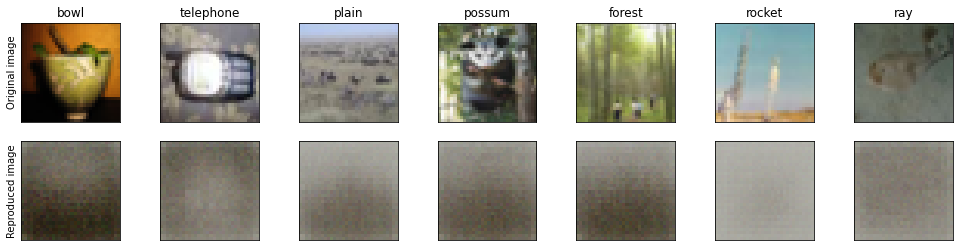

In [31]:

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


import matplotlib.pyplot as plt
model.eval()

def batchplot(batch_show,image):
# How many images from the batch will you show?


    def imshow(img):
        #img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            #plt.show()

    # Model reconstruction
    x_hat, _, _ = model(image)

    fig1=plt.figure(figsize=(17,4))
    fig1.patch.set_facecolor('white')
    for i in range(batch_show):

        plt.subplot(2,batch_show,i+1)
        imshow(image[i])
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title(classes[labels[i].item()])
        if i == 0:
            plt.ylabel('Original image')
        
        plt.subplot(2,batch_show,batch_show+ i+1)
        imshow(x_hat[i].detach())
        plt.xticks([],[])
        plt.yticks([],[])
        if i == 0:
            plt.ylabel('Reproduced image')
    pass


dataiter = iter(test_loader)
x, labels = dataiter.next()

x_hat, mean, var = model(x)


batch_show = 7

batchplot(batch_show,x)


Convert to python file!

In [28]:
!jupyter nbconvert --to script VAE_CIFAR100_test.ipynb

[NbConvertApp] Converting notebook VAE_CIFAR100_test.ipynb to script
[NbConvertApp] Writing 19107 bytes to VAE_CIFAR100_test.py
